In [1]:
%load_ext autoreload
%autoreload 2

# Modelo CNN con generador, embedings de smiles y data-augmentation

In [4]:
import pandas as pd
import numpy as np
from datagen import smiles_dict, smiles_to_seq

### smiles_dict

In [5]:
len(smiles_dict)

42

smiles_dict nos da un tokenizador para simplificar el problema. Puede ver como se construyó en la notebook **deep_chem**.
Si al momento de correr el modelo con este diccionario encuentra problemas de key_error, puede agregar los faltantes al diccionario

Mirar dentro de **datagen.py** como se usa este diccionario con la función **smiles_to_seq** para tokenizar. El código es muy sencillo

In [6]:
print(smiles_dict)

{'#': 1, '(': 2, ')': 3, '+': 4, '-': 5, '/': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '=': 15, 'C': 16, 'F': 17, 'H': 18, 'I': 19, 'N': 20, 'O': 21, 'P': 22, 'S': 23, '[': 24, '\\': 25, ']': 26, '_': 27, 'c': 28, 'Cl': 29, 'Br': 30, 'n': 31, 'o': 32, 's': 33, '@': 34, '.': 35, 'a': 36, 'B': 37, 'e': 38, 'i': 39, '9': 40, '10': 41, '11': 42}


# Carga de los datos

In [7]:
df = pd.read_csv('acetylcholinesterase_02_bioactivity_data_preprocessed_4.csv')

In [8]:
max_len_idx = df['canonical_smiles'].apply(len).argmax()
min_len_idx = df['canonical_smiles'].apply(len).argmin()
max_sequence_len = len(df['canonical_smiles'].iloc[max_len_idx]) + 20

In [9]:
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,standard_value_norm,pIC50,pIC50_2,canonical_len
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,750.0,6.124881,6.124881,37
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,100.0,6.999566,6.999566,42
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,50000.0,4.301029,4.301029,49
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,300.0,6.522734,6.522734,45
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,800.0,6.096856,6.096856,41


In [10]:
X = df['canonical_smiles'].values
y = df['pIC50'].values

# Data augmentation:

https://arxiv.org/pdf/1703.07076.pdf

https://github.com/EBjerrum/molvecgen

https://github.com/Ebjerrum/SMILES-enumeration

En la publicación de arriba se describe una técnica de aumentación de datos para los smiles. Leerla si es de su interes (Opcional)

En el módulo **dataug.py**, tomando como referencia los repositorios arriba citados se implementó la aumentación de datos

In [11]:
from dataaug import SmilesEnumerator
sme = SmilesEnumerator()
for i in range(10):
    print(sme.randomize_smiles('CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'))
    

c1(-n2nc(OCC)oc2=O)cccc(OCc2ccccc2)c1
c1c(-n2nc(OCC)oc2=O)cccc1OCc1ccccc1
c1(COc2cccc(-n3nc(OCC)oc3=O)c2)ccccc1
c1(OCc2ccccc2)cccc(-n2nc(OCC)oc2=O)c1
c1(OCC)nn(-c2cc(OCc3ccccc3)ccc2)c(=O)o1
c1(COc2cccc(-n3c(=O)oc(OCC)n3)c2)ccccc1
c1(=O)oc(OCC)nn1-c1cccc(OCc2ccccc2)c1
CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
c1(COc2cc(-n3c(=O)oc(OCC)n3)ccc2)ccccc1
O(c1cccc(-n2nc(OCC)oc2=O)c1)Cc1ccccc1


# DataGenerator

Construir un generador al que se le pase al instanciarlo:
- X: smiles (formula química)
- y: pIC50
- batch_size
- max_sequence_len (int): La máxima longitud de las secuencias (para hacer el padding)
- data_augmentation (boolean): si quiero hacer o no data-augmentation. 
- shuffle (boolean)

Guardarlo en el módulo **datagen.py** con el nombre de la clase **DataGenerator**

Notar que el módulo **datagen.py** ya tiene una estructura para completar

### Importamos el módulo y lo probamos

In [12]:
from datagen import DataGenerator

In [13]:
dgen = DataGenerator(X, y, max_sequence_len, batch_size=16)

In [14]:
len(dgen) * dgen.batch_size

5664

In [15]:
for i, (X_b, y_b) in enumerate(dgen):
    print(f'{i}\r', end='')

# Split

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
len(X_train), len(y_train), len(X_test)

(4531, 4531, 1133)

In [19]:
X_train

array(['COc1ccccc1NC(=S)NCCN(C)C', 'O/N=C/c1nc(Cc2ccccc2)no1',
       'O=C(NCCc1c[nH]c2ccccc12)c1ccc[n+](Cc2ccccc2F)c1.[Br-]', ...,
       'O=[N+]([O-])c1ccccc1-c1nnc(Nc2ncccn2)o1',
       'COc1cc2c(cc1O)CCC(C)(CCNCCCCCCCNc1c3c(nc4cc(Cl)ccc14)CCCC3)O2',
       'CN(C)Cc1ccc(CSCCCCCCCSCc2ccc(CN(C)C)o2)o1'], dtype=object)

In [20]:
dgen_train = DataGenerator(X_train, y_train, seq_length=max_sequence_len, batch_size=128, data_augmentation=True)
dgen_test = DataGenerator(X_test, y_test, seq_length=max_sequence_len, batch_size=128, data_augmentation=False)

In [21]:
for i, (X_b, y_b) in enumerate(dgen_test):
    print(f'{i}\r', end='')

In [22]:
X_b.shape

(109, 227)

# Network Model

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, Activation, BatchNormalization, Conv1D, MaxPool1D, GlobalAveragePooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import layers as L

In [400]:
# Implementar modelo de TextCNN
def text_cnn_1d(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters):
    # Recordar que estamos en la funcional model API y hay que entender que conectar con que.
    input_x = L.Input(shape=(sequence_length,), name='input_x')
    embedding = L.Embedding(vocab_size + 1, embedding_size, name='embedding')(input_x) #BLoque de embeddings
    pooled_outputs = []
    for filter_size in filter_sizes:
        conv = L.Conv1D(filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=1, activation='relu')(embedding) # Implementar
        max_p = L.MaxPool1D(100)(conv) # Implementar
        pooled_outputs.append(max_p)
        
    h_pool = L.Concatenate(axis=2)(pooled_outputs)
    dense = L.Flatten()(h_pool)
    dense = L.Dense(128, activation='relu')(dense) # Capa densa 1
    #drop = L.Dropout(0.5)(dense)
    #dense = L.Dense(128, activation='relu')(drop) # Capa densa 1
    #drop = L.Dropout(0.5)(dense)
    dense = L.Dense(32, activation='relu')(dense) # Capa densa 1
    dense = L.Dense(1)(dense) # Salida
    model = tf.keras.models.Model(input_x, dense)
    return model

In [401]:
# Puede cambiar estos hiperparámtros. Son solo de referencia
FILTER_SIZES = (3, 4, 5)
NUM_FILTERS = 256
vocab_size = len(smiles_dict)
embeddings_size = 128 # 2

In [402]:
model = text_cnn_1d(max_sequence_len, vocab_size, embeddings_size, FILTER_SIZES, NUM_FILTERS)
model.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_x (InputLayer)           [(None, 227)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 227, 128)     5504        ['input_x[0][0]']                
                                                                                                  
 conv1d_81 (Conv1D)             (None, 227, 256)     98560       ['embedding[0][0]']              
                                                                                                  
 conv1d_82 (Conv1D)             (None, 227, 256)     131328      ['embedding[0][0]']              
                                                                                           

In [403]:
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [404]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[R2])

In [405]:
mcp = ModelCheckpoint('models/best_model_{epoch}', save_best_only=True, save_format="h5")

In [406]:
from helper import PlotLosses
plot_losses = PlotLosses(1, None)

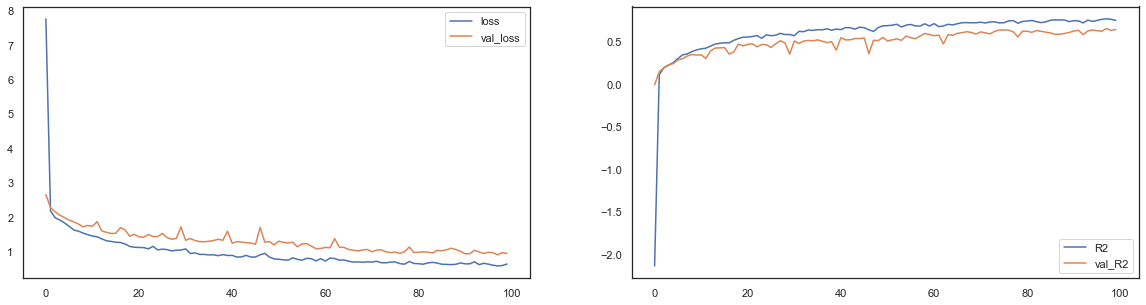

36/36 [==============================] - 46s 1s/step - loss: 0.6244 - R2: 0.7479 - val_loss: 0.9308 - val_R2: 0.6417


In [407]:
history = model.fit(dgen_train, epochs=100, validation_data=dgen_test, callbacks=[plot_losses])

In [408]:
X_test_eval = []
y_t_eval = []
for X_t, y_t in dgen_test:
    X_test_eval = X_test_eval + [list(t) for t in X_t]
    y_t_eval = y_t_eval + list(y_t)
X_test_eval = np.array(X_test_eval)
y_test = np.array(y_t_eval)

In [409]:
X_test_eval.shape, y_test.shape

((1133, 227), (1133,))

In [410]:
y_pred = model.predict(X_test_eval)

36/36 [==============================] - 2s 54ms/step


# Score

In [411]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()

In [412]:
r2


0.648007580207266

In [413]:
filename = 'models/embed_128_text_cnn_f256_MP100_aug_dense128x32_relu_0.001_ep100.h5'
model.save(filename)

# Resultados
##### embed_128_text_cnn_aug_dense128x32_0.0001_ep10 --> val_R2 = 0.2698412561376896
##### embed_128_text_cnn_aug_dense128x32_0.001_ep50 --> val_R2 = 0.5925943158760951
##### embed_128_text_cnn_aug_dense128x32_0.0001_ep50 --> val_R2 = 0.42243120308983073
   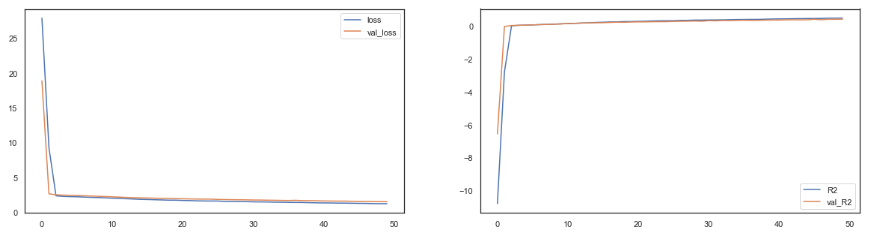
##### embed_128_text_cnn_aug_dense128x32_0.001_ep100 --> val_R2 = 0.6431233037738543
   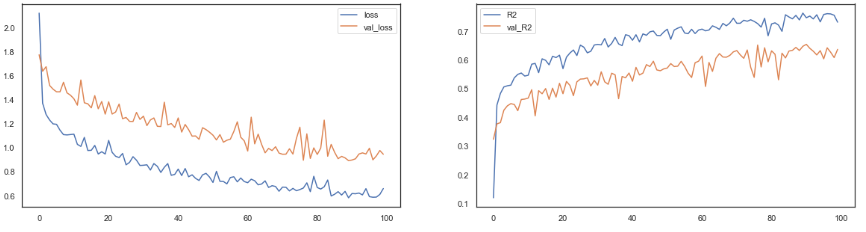
##### embed_128_text_cnn_aug_dense128x50_relu_0.001_ep100 --> val_R2 = 0.6205391296526361
   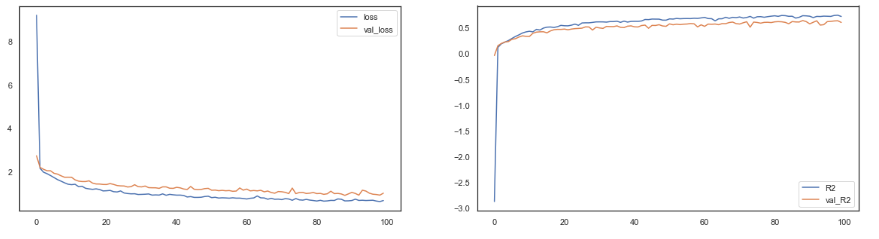
### Pruebo bajando el tamaño del embedding:
##### embed_64_text_cnn_aug_dense128x50_relu_0.001_ep50 --> val_R2 = 0.542803519161212    
   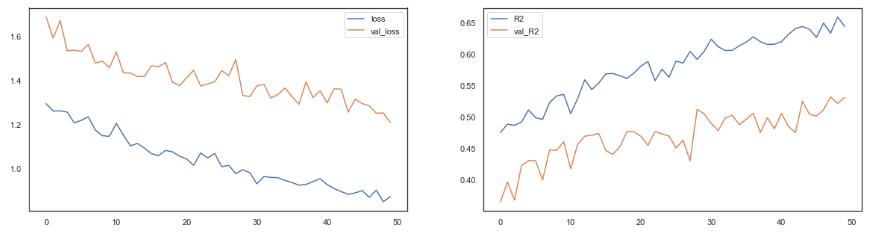
##### embed_64_text_cnn_aug_dense128x50_relu_0.001_ep100 --> val_R2 = 0.6199727824374335
   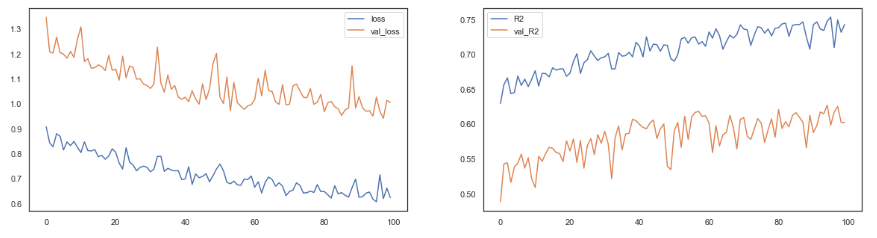
--> practicamente igual que con 128
### Cambio el tamaño del MaxPooling:
##### embed_64_text_cnn_MP50_aug_dense128x50_relu_0.001_ep100 --> val_R2 = 0.577419403362394
   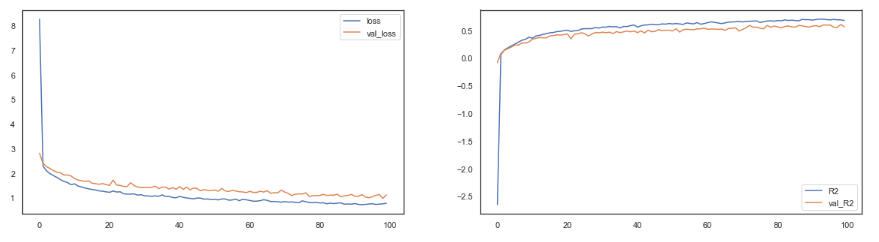
##### embed_64_text_cnn_MP5_aug_dense128x50_relu_0.001_ep100 --> val_R2 = 0.5465403465296901
--> empeora
### Pruebo bajando aun mas el tamaño del embedding:
##### embed_20_text_cnn_MP100_aug_dense128x50_relu_0.001_ep100 --> val_R2 = 0.5214945147094125
   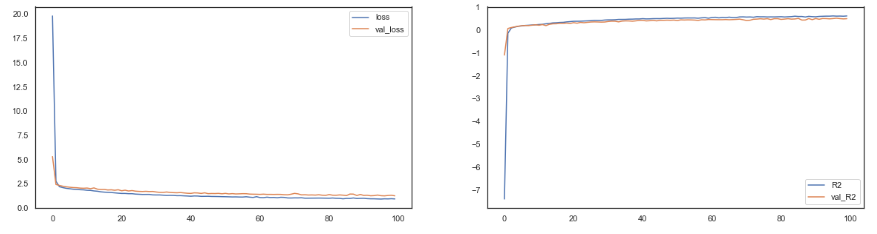
##### embed_20_text_cnn_MP20_aug_dense128x50_relu_0.001_ep100 --> val_R2 = 0.47971970256799046
##### embed_20_text_cnn_MP100_aug_dense128x50_relu_0.001_ep100 --> val_R2 = 0.4316542049715415
##### embed_10_text_cnn_f128_MP100_aug_dense128x32_relu_0.001_ep100 --> val_R2 = 0.510627971588677
##### embed_20_text_cnn_f128_MP100_aug_dense128x32_relu_0.001_ep100 --> val_R2 = 0.58884269332272
   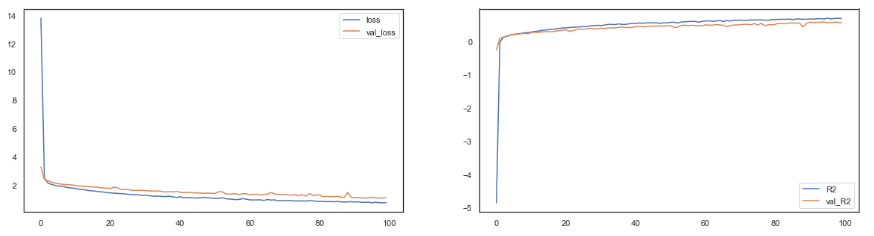
##### embed_20_text_cnn_f128_MP20_aug_dense128x50_relu_0.001_ep100 --> val_R2 = 0.5741771458941467
##### embed_30_text_cnn_f128_MP100_aug_dense128x50_relu_0.001_ep100 --> val_R2 = 0.6313310141225009
   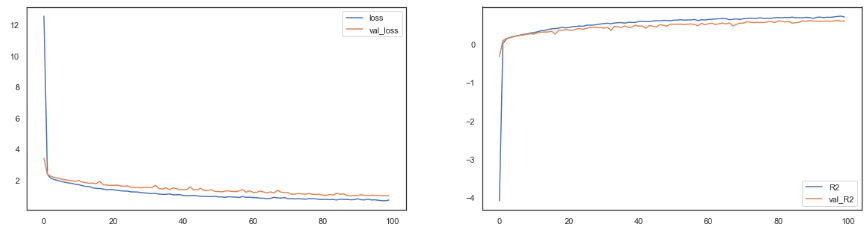
### Aumento la cant de filtros:
##### embed_30_text_cnn_f256_MP100_aug_dense128x50_relu_0.001_ep100 --> val_R2 = 0.6412248334593627
--> mejora muy poco
### Agrego una capa densa:
##### embed_30_text_cnn_f128_MP100_aug_dense128x128x50_relu_0.001_ep100 --> val_R2 = 0.5491610188883637
### Y dropout:
##### embed_30_text_cnn_f128_MP100_aug_dense128x128x50_drop03_relu_0.001_ep100 --> val_R2 = 0.51050
##### embed_30_text_cnn_f128_MP100_aug_dense128x128x50_drop05_relu_0.001_ep100 --> val_R2 = 0.53204
##### embed_30_text_cnn_f128_MP100_aug_dense128x128x50_drop08_relu_0.001_ep100 --> val_R2 = 0.4407787
   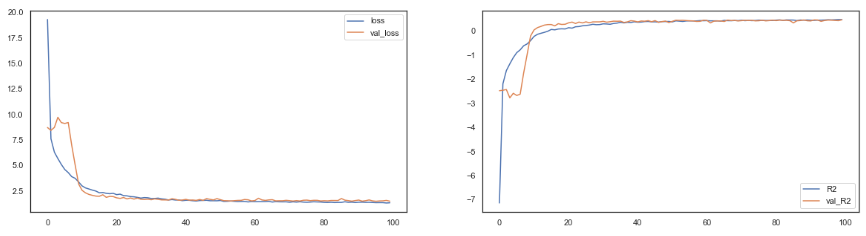
--> no parece ayudar
##### embed_128_text_cnn_f256_MP100_aug_dense128x32_relu_0.001_ep100 --> val_R2 = 0.648007580207266
--> mejora pero muy poco
   
   

# Load model (solo si se grabo el modelo)

In [80]:
from tensorflow.keras.models import load_model

In [394]:
model_loaded = load_model('models/embed_10_text_cnn_f128_MP100_aug_dense128x32_relu_0.001_ep100.h5', custom_objects={'R2': R2})

In [85]:
y_pred = model_loaded.predict(X_test_eval)

36/36 [==============================] - 1s 20ms/step


In [86]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
r2

0.5925943158760951

# Evaluación

<function matplotlib.pyplot.show(*args, **kw)>

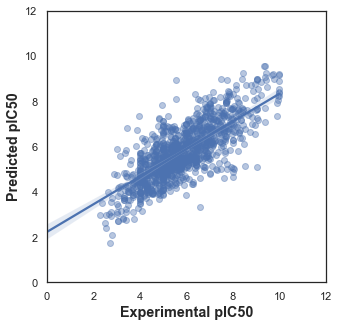

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

# TSNE

In [305]:
from sklearn.manifold import TSNE

In [396]:
embeddings = model_loaded.layers[1].get_weights()[0][1:]
embeddings.shape

(42, 10)

In [397]:
tsne = TSNE(2)
x_2d = tsne.fit_transform(embeddings)

D:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


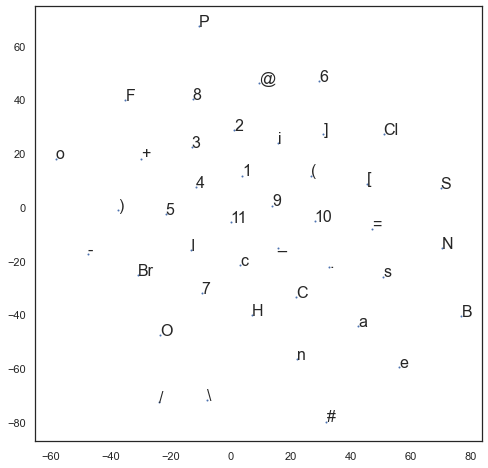

In [399]:
plt.figure(figsize=(8,8))
plt.scatter(x_2d[:, 0], x_2d[:, 1], s= 1)
for i, t in enumerate(smiles_dict):
    plt.text(x_2d[i, 0], x_2d[i, 1], t, fontsize=16)
    
plt.show()

No se observa un agrupamiento evidente, incluso utilizando embeddings mas chicos (o quizas habria que mirarlo con algun conocimiento quimico, a ver si los elementos que quedaron cercanos tiene algun sentido quimico).